# Views on Japanese Authors 

This notebook analyses the vocabulary used to describe male and female authors from Japan. 

In [198]:
import pandas as pd
import json
import os
from os.path import join
import tdm
import requests
from datetime import datetime
import re
import PyPDF2 
import ssl
from langdetect import detect
from bs4 import BeautifulSoup
from collections import Counter
from nltk import word_tokenize,sent_tokenize,pos_tag

import urllib.parse

## Frequently used words such as articles, pronouns and prepositions
from nltk.corpus import stopwords
stopword_list = stopwords.words('english')
stopword_list.extend(['/3','-+0','43+','/-1','m4/','https','//aboutjstororg/termsthis','-h1-3',
'sayaka','isbn','muse','gmt','leiden','downloaded','//aboutjstororg/termsthis',                   
'sanb˚e','tác','issn','murasaki','/aboutjstororg/termsthis','-h1-3' , 'gmailcom'])

import string
for punct_mark in string.punctuation:
    stopword_list.append(punct_mark)
    
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

In [ ]:
def encode_doi(DOI):
    DOI = re.sub(r'[.]','#',DOI)
    DOI = re.sub(r'\/','=',DOI)
    return DOI

def decode_doi(DOI):
    DOI = re.sub(r'#','.',DOI)
    DOI = re.sub(r'=',r'\/',DOI)
    return DOI

def get_filename(DOI):
    DOI = re.sub(r'[\.\/-_]','',DOI)
    return DOI

doi_gender = dict()

We will consider the following authors:

In [199]:
male_authors = [
'Haruki Murakami',
'Sosuke Natsukawa',
'Osamu Dazai',
'Yukio Mishima',
'Soseki Natsume',
'Toshikazu Kawaguchi',
'Junichiro Tanizaki',
'Kenji Miyazawa',
'Yasunari Kawabata',
'Kobo Abe',
'Ryu Murakami',
'Tomihiko Morimi',
'Keigo Higashino',
'Kenzaburo Oe',
'Tsutomu Minakami',
'Ranpo Edogawa',
'Shusaku Endo',
'Seishi Yokomizo',
'Genki Kawamura',
'Kenko Yoshida' 
]

female_authors = [ 
'Mieko Kawakami',
'Hiromi Kawakami',
'Yoko Tawada',
'Natsuko Imamura',
'Yuko Tsushima',
'Sayaka Murata',
'Yoko Ogawa',
'Hiroko Oyamada',
'Miri Yu',
'Asako Yuzuki',
'Sayaka Murata',
'Banana Yoshimoto',
'Yuko Tsushima',
'Risa Wataya',
'Mitsuyo Kakuta',
'Natsuo Kirino',
'Miyuki Miyabe',
'Ichiyo Higuchi',
'Riku Onda',
'Murasaki Shikibu' 
]

authors = male_authors + female_authors
for author in authors:
    first_name = author[:index_space].strip().lower()
    last_name = author[index_space+1:].strip().lower()
    stopword_list.append(first_name.lower())
    stopword_list.append(last_name.lower())


## Collect references to articles using Crossref

This notebook collects academic publications using the Crossref API. Crossref is the organisation which mints and manages DOI for publications and datasets. 

More information about this API can be found on [Crossref's website](https://www.crossref.org/documentation/retrieve-metadata/rest-api/a-non-technical-introduction-to-our-api/)

The base url of the API for academic publications is 

```
https://api.crossref.org/works
```

The API can be used with the following parameters:

* **query**: a term to search for. 
* **rows**: the number of publications to be included in the result set. The maximum number of rows is 500. 
* In the **filter**, it is possible to specify a start date using **from-pub-date**, and an end date using  **until-pub-date**. 

On the cell below, we collect references to academic works about each of the 20 authors that were selected. 

In [ ]:
def get_items(json_data):
    
    rows = []
    
    for item in json_data:
        data = dict()

        date = ''
        date_parts = item['published']['date-parts'][0] 
        for i,part in enumerate(date_parts):
            date += f'{part}'
            if i < len(date_parts)-1:
                date += '-'
        data['date'] = date
        
        
        if re.search(r'\d{4}-\d{1,2}-\d{1,2}',date):
            year = datetime.strptime(date, '%Y-%m-%d').year
        elif re.search(r'\d{4}-\d{1,2}',date):
            year = datetime.strptime(date, '%Y-%m').year
        elif re.search(r'\d{4}',date):
            year = datetime.strptime(date, '%Y').year
            
        data['year'] = int(year)
        
        if 'author' in item:
            authors = []
            for author in item['author']:
                author_name = ''
                author_name += author.get('given','')
                author_name += ' ' + author.get('family','')
                authors.append(author_name.strip())
            if len(authors)>0:
                data['author'] = authors
        data['doi'] = item['DOI']
        if 'publisher' in item:
            data['publisher'] = item['publisher']
        
        if 'subject' in item:
      
            subjects = []
            for subject in item['subject']:
                subjects.append(subject)
            if len(subjects)>0:
                data['subject'] = subjects
        if 'abstract' in item:
            data['abstract'] = item['abstract']     
        if 'container-title' in item:
            journal_title = item['container-title'][0]
            journal_title = re.sub( '\s+' , ' ' , str(journal_title) )
            journal_title = re.sub( '\s+&amp;\s+' , ' & ' , str(journal_title) )
            data['journal'] = journal_title
#             discipline = journals_dict[journal_title]
#             data['discipline'] = discipline
        
        data['type']=item['type']
        if 'title' in item:
            title = item['title'][0]
        if 'subtitle' in item:
            title += ': ' + item['subtitle'][0]
        data['title']=title
        if 'link' in item:
            links = []
            for url in item['link']:
                links.append(url['URL'])
            if len(links)>0:
                data['link']=links
        rows.append(data)
        
    return rows

In [ ]:


for author in authors:
    print(author)
    index_space = author.index(' ')
    first_name = author[:index_space].strip()
    last_name = author[index_space+1:].strip()
    
    results = []

    query_nr = 0
    query = urllib.parse.quote(author)
    cursor = '*'
    rows = 500
    publ_type = 'journal-article'
    start_date = '2013-01-01'
    end_date = '2023-12-31'

    headers = {'User-Agent':'mailto:p.a.f.verhaar@hum.leidenuniv.nl'}

    url = f'https://api.crossref.org/works?query=%22{query}%22&cursor={cursor}&rows={rows}'

    if re.search(r'\d',start_date) and re.search(r'\d',end_date):
        url += f'&filter=type:{publ_type},from-pub-date:{start_date},until-pub-date:{end_date}'

    print(url)

    response = requests.get(url,headers=headers)
    json_data = response.json()

    print( f"{json_data['message']['total-results']} results. ")
    nr_items = len(json_data['message']['items'])

    query_nr += 1
    print(f"{query_nr}: items {(query_nr*rows)-rows}-{query_nr*rows}")


    data = get_items(json_data['message']['items'])

    for article in data:
        
        article_authors = ''
        if 'author' in article:
            json_authors = article['author']
            for article_author in json_authors:
                article_authors += article_author + ' '       
                        
        if not(re.search(r'{}'.format(last_name),str(article_authors))) and not(re.search(r'{}'.format(first_name),str(article_authors))):
            article['author'] = author
            results.append(article)
            print(article['title'])
       
            
    next_cursor = ''
    if 'next-cursor' in json_data['message']:
        next_cursor = json_data['message']['next-cursor']

    while re.search( r'\w+' , next_cursor) and nr_items>0:

        url = f'https://api.crossref.org/works?query=%22{query}%22&cursor={next_cursor}&rows={rows}'

        if re.search(r'\d',start_date) and re.search(r'\d',end_date):
            url += f'&filter=type:{publ_type},from-pub-date:{start_date},until-pub-date:{end_date}'
            print(url)
        response = requests.get(url,headers=headers)
        json_data = response.json()
        query_nr += 1
        print(f"{query_nr}: items {(query_nr*rows)-rows}-{query_nr*rows}")

        if 'items' in json_data['message']:
            nr_items = len(json_data['message']['items'])
            data = get_items(json_data['message']['items'])
            for article in data:

                article_authors = ''
                if 'author' in article:
                    json_authors = article['author']
                    for article_author in json_authors:
                        article_authors += article_author + ' '    


                if not(re.search(r'{}'.format(last_name),str(article_authors))) and not(re.search(r'{}'.format(first_name),str(article_authors))):
                    article['author'] = author
                    results.append(article)
                    print(article['title'])

        next_cursor = ''
        if 'next-cursor' in json_data['message']:
            next_cursor = json_data['message']['next-cursor']
            
    json_object = json.dumps(results, indent = 4) 
    with open(f'Corpus_Japanese/{author}_articles.json','w',encoding='utf-8') as out:
        out.write(json_object)            


In [ ]:
print(f'{len(DOIs)} DOIs were found.')

In [ ]:
directory = 'Corpus_japanese'

DOIs_male = []
DOIs_female = []
author_names = []

for a in male_authors:
    json_file = open(os.path.join('Corpus_japanese','Authors',f'{a}_articles.json'),encoding='utf-8') 
    json_data = json.load(json_file)
    
    for item in json_data:
        DOI = item['doi']
        author_names.append(item['author'])
        DOIs_male.append(DOI)
        doi_gender[encode_doi(DOI)] = 'male' 
        
for a in female_authors:
    json_file = open(os.path.join('Corpus_japanese','Authors',f'{a}_articles.json'),encoding='utf-8') 
    json_data = json.load(json_file)

    for item in json_data:
        DOI = item['doi']
        author_names.append(item['author'])
        DOIs_female.append(DOI)
        doi_gender[encode_doi(DOI)] = 'female' 
        
DOIs = DOIs_male+DOIs_female
print(f'{len(DOIs)} DOIs were found.')

In [ ]:
male = [a for a in author_names if a in male_authors]
print(f'{len(male)} articles by male authors were found.')
      
authors_freq = Counter(male)
for author,count in authors_freq.most_common():
    print(f'{author}: {count}')

female = [a for a in author_names if a in female_authors]
print(f'\n\n{len(female)} articles by female authors were found.')
      
authors_freq = Counter(female)
for author,count in authors_freq.most_common():
    print(f'{author}: {count}')



## Acquisition of PDF files 

The PDS of Open Access journals are downloaded.

In [ ]:
download_urls = dict()
doi_title = dict()

for DOI in DOIs:
    url = f'http://api.crossref.org/works/{DOI}'
    print(url)
    response = requests.get(url)
    if response:
        json_data = response.json()
        message = json_data['message']
        
        title = ''
        if 'title' in message:
            title = message['title'][0]
            doi_title[encode_doi(DOI)] = title
            print(doi_title[encode_doi(DOI)])
        
        licence = 'Unknown'
        if 'licence' in message:
            for license in message['license']:
                licence = license['URL']
                
        content_type = "application/pdf"
        publ_url = 'unknown'
        if 'link' in message:
            publ_url = message['link'][0]['URL']
            if 'content-type' in message['link'][0]:
                download_urls[DOI] = (publ_url,content_type,licence)
            

In [ ]:
for DOI in download_urls:
    print(f'{DOI} => {encode_doi(DOI)}')

    try:

        file_name = encode_doi(DOI)
        if re.search( r'xml$', download_urls[DOI][1] ):
            file_name = f'{file_name.strip()}.xml'
        else:
            file_name = f'{file_name.strip()}.pdf'
 
        publ_url = download_urls[DOI][0]
        print(publ_url)
        
        if publ_url not in ['http://bcjjl.org/upload/pdf/bcjjlls-9-1-257.pdf',
                           'https://ojs.badanbahasa.kemdikbud.go.id/jurnal/index.php/jentera/article/viewFile/3971/2114']:

            text_response = requests.get(publ_url)
            if text_response.status_code == 200:

                path = os.path.join(directory,'Articles',file_name)
                pdf = open(path, 'wb')
                pdf.write(text_response.content)
                pdf.close()
                print(f'Download successful!')
            else:
                print(f'Issue with {publ_url}')
                print(download_urls[DOI][2])
                

    except Exception as error:
        print(f'Issue with {publ_url} {error}')


The plain text is extracted from the PDF files.

In [ ]:
files = [os.path.join(directory,'Articles',pdf) for pdf in os.listdir(os.path.join(directory,'Articles')) if re.search(r'pdf$',pdf)]
                                                           
non_pdf = []

for pdf in files:
    
    full_text = ''
    
    try:
        reader = PyPDF2.PdfFileReader(pdf)
        for page in reader.pages:

            page = reader.pages[0]
            text = page.extractText()
            text = re.sub(r'\s+',' ',text.strip())
            full_text += text

        full_text = full_text.strip()
        if len(full_text)>0:
            lang = detect(full_text)                                                        
            file_name = os.path.basename(pdf)
            file_name = re.sub(r'[.]pdf$','',file_name)                                         
            path = os.path.join(directory,'TXT',f'{file_name}_{lang}.txt')  
                                                           
            with open(path,'w',encoding='utf-8') as out:
                out.write(full_text)
        else:
            non_pdf.append(pdf)
    except:
        non_pdf.append(pdf)

In [ ]:
for path in non_pdf:
    with open(path,encoding='utf-8') as fh:
        try:
            xml_file = fh.read()
            soup = BeautifulSoup(xml_file, "lxml")
            full_text = soup.find('body').text
            if len(full_text)>0:
                lang = detect(full_text)

                                       
                file_name = os.path.basename(path)
                file_name = re.sub(r'[.]xml$','',file_name) 
                file_name = re.sub(r'[.]pdf$','',file_name) 
            
                                                      
                path = os.path.join(directory,'TXT',f'{file_name}_{lang}.txt')

                with open(path,'w',encoding='utf-8') as out:
                    out.write(full_text)
        except:
            print(f'Problem with {path}')


There are articles in different languages. This notebook only focuses on the 51 Open Access academic articles in English. 

In [136]:
OA_dois = []

files = os.listdir(os.path.join(directory,'TXT'))

languages = []
for file in files:
    language = file[-6:-4]
    languages.append(language)
language_freq = Counter(languages)

for language,count in language_freq.most_common():
    if not(re.search('_',language)):
        print(f"{language}\t{count}")

        

en	45
id	12
pt	12
de	8
es	5
ca	5
fr	2
pl	2
vi	2
da	1
th	1


In [177]:
files = [file for file in files if re.search('_en.txt',file)]
dois = [re.sub('_en.txt','',file) for file in files]

## The following toll access articles have been added
## To ensure that there is balance between the number of articles
## in teh two groups. 

doi_gender['emw26431282']= 'female'
doi_gender['jwl-article-p259_9'] = 'female'
doi_gender['1010800955580320161189448'] = 'female'
doi_gender['101353jjs20150024'] = 'female'
doi_gender['25064492'] = 'female'
doi_gender['27159896'] = 'female'
doi_gender['855558'] = 'female'
doi_gender['1010800955580320191614648'] = 'female'
doi_gender['1010800269005520201721115'] = 'female'
doi_gender['101111gequ12032'] = 'female'

doi_title['emw26431282']= 'Beyond The Tale of Genji: Murasaki Shikibu as Icon and Exemplum in Seventeenth- and Eighteenth-Century Popular Japanese Texts for Women'
doi_title['jwl-article-p259_9'] = 'Eating Murasaki Shikibu: Scriptworlds, Reverse-Importation, and The Tale of Genji'
doi_title['1010800955580320161189448'] = 'Invoking affect in Kawakami Mieko\'s Chihi to ran (Breasts and Eggs, 2008): Higuchi Ichiyô, playful words and ludic gestures'
doi_title['101353jjs20150024'] = 'The Cult of Happiness: Maid, Housewife, and Affective Labor in Higuchi Ichiyō’s “Warekara”'
doi_title['25064492'] = 'Happiness Foreclosed: Sentimentalism, the Suffering Heroine, and Social Critique in Higuchi Ichiyō\'s "Jūsan\'ya"'
doi_title['27159896'] = 'The Thirty-Something “Tokyo Daughters” of Kawakami Hiromi’s Strange Weather in Tokyo, Shibasaki Tomoka’s Spring Garden, and Murata Sayaka’s Convenience Store Woman'
doi_title['855558'] = 'Androids for the Stone Age?: Individuality, Space, and Gender in Murata Sayaka\'s Convenience Store Woman'
doi_title['1010800955580320191614648'] = 'Fidelity to the dead: the question of complicity in Tsushima Yûko\’s Wildcat Dome'
doi_title['1010800269005520201721115'] = 'An Interview with Mieko Kawakami'
doi_title['101111gequ12032'] = 'Representations of Public Spaces and the Construction of Race in Yoko Tawada\’s “Bioskoop der Nacht”'

gender = Counter()
all_gender = []

male_dois = []
female_dois = []
#print(len(female_dois))

for doi in dois:
    if doi_gender[doi] == 'male':
        male_dois.append(doi)
    elif doi_gender[doi] == 'female':
        female_dois.append(doi)


male_dois = male_dois[:15]
female_dois = female_dois[:15]




print('English Articles on male Japanese authors:\n')

for doi in male_dois:
    print(doi_title[doi])
    
    

print('\nEnglish Articles on female Japanese authors:\n')

for doi in female_dois:
    print(doi_title[doi])
      

English Articles on male Japanese authors:

Two genre classification of Japanese literary works written by Ryuunosuke Akutagawa and Kenji Miyazawa based on word vectors
Analysis Figure of Speech and Theatrical Story In No Longer Human Novel by Osamu Dazai
Acceptance and Commitment Therapy is "Haruki Murakami"
Analysis on Haruki Murakami's Barn Burning—Focusing on the Metaphor in the Story
Mari Asai’s Personal Isolation in Haruki Murakami’s After Dark
Analisis Sosiolinguistik Politeness Bahasa Jepang dalam Film Galileo 2013 Karya Keigo Higashino
The applicability of Big Five facets and Dark Tetrad traits on Yukio Mishima’s novel protagonists
The Hospital as An Ideological State Apparatus and Disciplinary Agent as Seen through the Main Character in Kenzaburo Oe�s A Personal Matter
An Analysis of Stylistic in After Dark by Haruki Murakami
Exploring the intersection of Anton Chekhov and Haruki Murakami: a slow reading analysis of “Drive My Car”
A likely case of progression from mild cognit

## Text Mining



In [178]:
def clean_wordlist(words):
    words = [word for word in words if word not in stopword_list]
    words = [word for word in words if len(word.strip())>2]
    words = [re.sub(r'([….])|(\')','',word) for word in words]
    words = [word for word in words if len(re.sub(r'(\d)|([\/\+\-,:])','',word))>0]
    words = [word.lower() for word in words if re.search(r'\w', word)]
    return words

In [192]:
male_freq = Counter()
female_freq = Counter()

corpus_male = []
corpus_female = []

for doi in male_dois: 
    path = os.path.join('Corpus_Japanese','TXT',f'{doi}_en.txt')
    corpus_male.append(path)

    text = open(path,encoding='utf-8')
    full_text = text.read()
    words = word_tokenize(full_text.lower())
    words = clean_wordlist(words)
    male_freq.update(words)
    
for doi in female_dois: 
    path = os.path.join('Corpus_Japanese','TXT',f'{doi}_en.txt')
    corpus_female.append(path)

    text = open(path,encoding='utf-8')
    full_text = text.read()
    words = word_tokenize(full_text.lower())
    words = clean_wordlist(words)
    female_freq.update(words)
    

### Most frequent words in articles on male authors

In [185]:
for word,count in male_freq.most_common(30):
    print(f'{word} => {count}')

keigo => 288
murakami => 270
story => 263
haruki => 257
novel => 188
used => 173
study => 172
use => 146
literary => 133
literature => 132
hospital => 131
short => 126
life => 125
research => 122
anxiety => 115
language => 110
based => 109
mono => 108
work => 107
social => 102
translation => 100
town => 98
cats => 98
people => 95
abstract => 94
japanese => 94
speech => 90
data => 89
world => 85
theory => 83


### Most frequent words in articles on female authors

In [186]:
for word,count in female_freq.most_common(30):
    print(f'{word} => {count}')

genji => 315
women => 244
tale => 235
japanese => 230
mama => 162
group => 136
monogatari => 128
university => 121
tomo => 117
dan => 117
novel => 109
shikibu => 98
three => 96
minamoto => 96
read => 85
readers => 78
study => 76
society => 70
alienation => 70
long => 69
literature => 68
female => 68
world => 67
subject => 67
journal => 66
translation => 65
tales => 65
japan => 64
fictional => 64
jewels => 64


### Words used ONLY in articles on male authors

In [189]:
for word,count in male_freq.most_common(100):
    if word not in female_freq.keys():
        print(word)

keigo
hospital
mono
town
cats
speech
data
bird
entitled
tengo
kawana
universitas
utterance
namely
bahasa
galileo
sonkeigo
kenjougo
teineigo
sachiko
uchi
partners
soto
google
qualitative
disciplinary
baby
results
humans
speaker
tells


### Words used ONLY in articles on female authors

In [194]:
for word,count in female_freq.most_common(100):
    if word not in male_freq.keys() and word not in stopword_list:
        print(word)

genji
women
mama
monogatari
tomo
shikibu
minamoto
alienation
tales
jewels
tamenori
project
kelompok
authenticity
stratification
embodiment
multan
existentialism
classic
script
prose
complex
indeed
breasts
eggs
lumc
primarily
audience
body
feminist
heian
widely
exceedingly
identified
remain
label


### Distinctive words

In [204]:
def calculate_word_frequencies(corpus):

    freq = Counter()
    for text in corpus:
        full_text = ''
        file_handler = open(text,encoding='utf-8')
        full_text = file_handler.read()
        words = word_tokenize(full_text.lower())
        words = clean_wordlist(words)
        freq.update(words)

    return freq

In [205]:
from tm import log_likelihood, sorted_by_value

freq1 = calculate_word_frequencies(corpus_male)
total1 = sum(freq1.values())

freq2 = calculate_word_frequencies(corpus_female)
total2 = sum(freq2.values())

Which used are used most frequently in the articles on male authors, if compared to the frequencies in the articles by female authors?

In [209]:
ll_scores = dict()


for word in freq1.keys():
    if word in freq2.keys():

        ll_score = log_likelihood( freq1[word] , freq2[word] , total1 , total2 )
        ll_scores[word] = ll_score

max = 25
i = 0 
        
for word in sorted_by_value(ll_scores , ascending = False ):
    print( word , ll_scores[word] )
    i += 1
    if i == max: 
        break  

story 247.6425196137883
anxiety 124.2423122895864
short 117.74403588215971
used 94.95588141183018
life 69.49439825131792
distance 68.84101651591166
age 65.93393389170957
show 63.29409716376378
literary 60.024981089818354
based 57.60774896193466
research 57.25547459329998
film 56.869596542069296
date 55.73916365170223
power 54.93643289903723
find 54.46559815629393
ideology 52.35185931119826
language 51.479526920351255
position 51.17234412030269
less 50.07700074937955
man 49.680334395854956
gmailcom 47.77114521987985
person 47.54977867824978
said 46.72128755682202
works 45.975890819025764
state 42.35336596497723


Which used are used most frequently in the articles on female authors, if compared to the frequencies in the articles by male authors?

In [211]:
max = 25
i = 0 

for word in sorted_by_value(ll_scores ) :
    print( word , ll_scores[word] )
    i += 1
    if i == max:
        break   

tale -355.2148053016438
female -101.80434048822103
trans -95.38986561733938
japanese -95.1039315670825
woman -87.38272921675936
three -83.6278703328577
fictional -83.5553715861997
subject -83.34135724314697
long -81.95573302709406
dan -66.17274195400381
read -64.40541008194549
group -63.95780285049318
wrote -57.585761646409985
early -50.06422410274898
male -44.482261276463966
discussed -44.482261276463966
content -44.400703769469345
called -40.91223864948137
century -40.32798614708028
texts -38.89699846335773
class -38.210142799706965
english -38.10160250502497
perhaps -37.47128609092386
rich -36.758473469073415
although -36.587193270625235


### Part of Speech Tagging

Which adjectives are used most frequently in articles on male authors?

In [215]:
male_adjectives = []
male_nouns = []

for doi in male_dois: 
    path = os.path.join('Corpus_Japanese','TXT',f'{doi}_en.txt')
    text = open(path,encoding='utf-8')
    full_text = text.read()
    words = word_tokenize(full_text.lower())
    words = clean_wordlist(words)
    
    pos = pos_tag(words)

    for p in pos:
        if re.search( '^JJ',p[1] ):
            male_adjectives.append(p[0])
        if re.search( '^NN',p[1] ):
            male_nouns.append(p[0])

adj_freq_male = Counter(male_adjectives)
for w,c in adj_freq_male.most_common(20):
    print(w,c)

literary 131
short 126
novel 118
social 102
japanese 94
human 71
hospital 65
universitas 64
uchi 54
qualitative 52
disciplinary 52
main 49
different 47
abstract 44
acceptable 42
readable 42
superego 42
personal 41
structural 41
various 38


Which adjectives are used most frequently in articles on female authors?

In [217]:
female_adjectives = []
female_nouns = []

for doi in female_dois: 
    path = os.path.join('Corpus_Japanese','TXT',f'{doi}_en.txt')
    text = open(path,encoding='utf-8')
    full_text = text.read()
    words = word_tokenize(full_text.lower())
    words = clean_wordlist(words)
    
    pos = pos_tag(words)

    for p in pos:
        if re.search( '^JJ',p[1] ):
            female_adjectives.append(p[0])
        if re.search( '^NN',p[1] ):
            female_nouns.append(p[0])

adj_freq_female = Counter(female_adjectives)
for w,c in adj_freq_female.most_common():
    print(w,c)

japanese 229
tale 166
novel 67
female 67
fictional 64
tamenori 64
english 63
new 55
subject 52
many 42
classic 40
social 38
early 37
popular 37
mama 36
complex 35
prose 35
cultural 34
least 34
modern 33
rich 33
heian 33
prominent 33
entire 33
abstract 32
dystopian 32
exemplum 32
seventeenth- 32
eighteenth- 32
major 32
lady-in-waiting 32
empress 32
syllabic 32
ﬁwoman™s 32
discussed 32
exclusive 32
murasaki™s 32
generic 32
male 32
highest 32
edward 32
center 32
michigan 32
hotaru 32
tamakazura 32
typical 32
tyler 32
international 30
=2- 30
a-d 30
e+/0 30
0-e+ 30
l-m- 30
nc=c1co+ 30
e-2 30
:42rsr 30
t-3+ 30
feminist 29
human 26
literary 24
emissary 24
environmental 24
apocalyptic 24
foreign 23
main 23
chinese 20
genji 19
available 19
write 18
informal 18
penelitian 18
sosial 18
ukuran 18
february 17
domestic 16
different 16
philosophical 16
contemporary 16
financial 15
bad 15
national 14
public 14
aniqua 14
munawar 14
chaudhary 14
dime 14
workforce 14
invidious 14
patriarchal 14
strait 14

Which frequent adjectives from the articles on male authors are NEVER used in articles on female authors?

In [220]:
for word,count in adj_freq_male.most_common():
    if word not in adj_freq_female.keys():
        print(word , count)

hospital 65
universitas 64
uchi 54
qualitative 52
disciplinary 52
readable 42
superego 42
structural 41
various 38
dian 36
sachiko 36
respectful 36
norwegian 32
stylistic 28
surakarta 28
slow 22
theatrical 18
sonkeigo 18
use 18
sociolinguistic 18
descript 18
ive 18
speech 18
higher 18
dominant 18
untuk 18
lingkungan 18
ide 18
scholar 18
higashinojapanese 17
daily 17
psychoanalytic 16
successful 15
adapt 15
cognitive 15
accompany 14
bildungsro 14
maret 14
maxim 14
equivalent 14
discursive 14
accurate 14
speaker 14
permatasari 14
legitimate 14
uly 14
electrum 14
ahmad 14
kinds 14
descr 14
referential 14
significant 14
pradopo 14
experi 14
reliant 14
indivisible 14
tengo 14
father 14
wardani 13
usdacid 13
dharma 13
unruly 13
ird 13
judgment 13
birth 13
bird 13
intensive 13
undergone 13
unnatural 13
heal 13
reinforcement 13
french 13
structural-marxist 13
antonio 13
civil 13
economic 13
psychological 12
sympathy 11
big 11
udc 11
olga 11
spachil 11
russian 11
predominant 11
en- 11
musical 1

Which frequent adjectives from the articles on female authors are NEVER used in articles on male authors?

In [222]:
for word,count in adj_freq_female.most_common():
    if word not in adj_freq_male.keys():
        print(word , count)

tale 166
tamenori 64
classic 40
mama 36
complex 35
prose 35
heian 33
entire 33
dystopian 32
exemplum 32
seventeenth- 32
eighteenth- 32
lady-in-waiting 32
empress 32
syllabic 32
ﬁwoman™s 32
discussed 32
exclusive 32
murasaki™s 32
generic 32
highest 32
edward 32
center 32
michigan 32
hotaru 32
tamakazura 32
tyler 32
=2- 30
a-d 30
e+/0 30
0-e+ 30
l-m- 30
nc=c1co+ 30
e-2 30
:42rsr 30
t-3+ 30
feminist 29
emissary 24
environmental 24
apocalyptic 24
genji 19
write 18
sosial 18
ukuran 18
february 17
domestic 16
philosophical 16
financial 15
national 14
public 14
aniqua 14
munawar 14
chaudhary 14
dime 14
workforce 14
invidious 14
patriarchal 14
strait 14
eggs 14
unveil 14
embodiment 14
faith 14
quest 14
authentic 14
obtainable 14
small 13
//ijlcwumedupk/indexphp/ojsinternational 13
™smemoirsofapolarbear 13
pennyyeungisaphdcandidateincom- 13
translationstudiesinmultilingual 13
memoirsofapolar 13
thesepassagesfromthebook 13
ienteredthestorybeingtoldasitspro- 13
boldpro- 13
nouncementswescarcelyth

### Sentiment Analysis

The cell outputs sentences in the articles on male authors which have a sentiment score of less than -0.5.

In [305]:
data = []

nr_sentences = 0
count_positive = 0
count_negative = 0
male_sentences = dict()

for doi in male_dois: 
    path = os.path.join('Corpus_Japanese','TXT',f'{doi}_en.txt')
    text = open(path,encoding='utf-8')
    full_text = text.read()
    sentences = sent_tokenize(full_text)
    for sentence in sentences:
        scores = ana.polarity_scores(sentence)
        nr_sentences += 1
        if scores['compound'] > 0.5:
            count_positive+=1
        elif scores['compound'] < -0.5:
            count_negative+=1
        male_sentences[sentence] = scores['compound']
        

count_neutral = nr_sentences - count_positive-count_negative

data.append( ['Male',count_neutral/nr_sentences,count_positive/nr_sentences,count_negative/nr_sentences] )

The cell outputs sentences in the articles on female authors which have a sentiment score of less than -0.5.

In [306]:
nr_sentences = 0
count_positive = 0
count_negative = 0
female_sentences = dict()

for doi in female_dois: 
    path = os.path.join('Corpus_Japanese','TXT',f'{doi}_en.txt')
    text = open(path,encoding='utf-8')
    full_text = text.read()
    sentences = sent_tokenize(full_text)
    for sentence in sentences:
        scores = ana.polarity_scores(sentence)
        nr_sentences += 1
        if scores['compound'] > 0.5:
            count_positive+=1
        elif scores['compound'] < -0.5:
            count_negative+=1
            female_sentences[sentence] = scores['compound']
        

count_neutral = nr_sentences - count_positive-count_negative

data.append( ['Female',count_neutral/nr_sentences,count_positive/nr_sentences,count_negative/nr_sentences] )

In [307]:
df = pd.DataFrame(data,columns=['gender','neutral','positive','negative'])

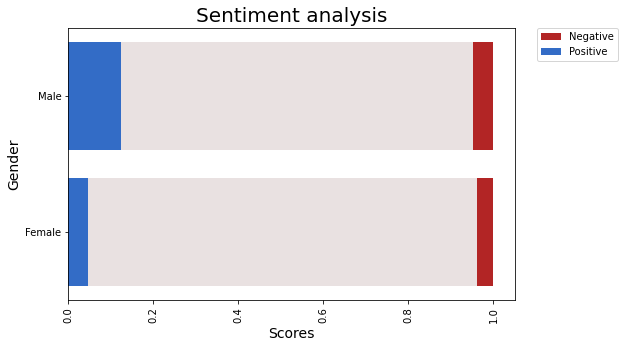

In [308]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


y_axis = 'gender'

fig = plt.figure( figsize=( 8 , 5 ) )

df['combined'] = df['positive'] + df['neutral'] + df['negative']
graph = sns.barplot( data=df , x='combined', y=y_axis , label = 'Negative', color = '#c90e0e' )
df['combined'] = df['combined'] - df['negative']
graph = sns.barplot( data=df , x='combined', y=y_axis , color = '#ebdfdf')
df['combined'] = df['combined'] - df['neutral']
graph = sns.barplot( data=df , x='combined', y=y_axis , label = 'Positive' ,color = '#1b66de')

graph.set_title('Sentiment analysis' , size = 20) 
graph.set_xlabel('Scores' , size = 14) 
graph.set_ylabel('Gender' , size = 14 )

plt.xticks(rotation= 90)

# The next line places the legend outside out the plot
plt.legend( bbox_to_anchor=(1.05, 1),loc=2, borderaxespad=0.);

plt.show()

### Most negative sentence in articles on male authors

In [317]:
import tm


for i,sentence in enumerate(tm.sorted_by_value(male_sentences)):
    if i< 15:
        print(f"{sentence}\n{male_sentences[sentence]}")
    else:
        break

The Sense of Loneliness, Blockage, and Emptiness in Haruki Murakami’s Works
When we discuss the problems of the sense of loneliness, blockage, and emptiness in Haruki Murakami’s works, we must first understand the characteristics of these feelings described by him.
-0.9201
Excessive fear or anxiety can make a person drown in his bad imagination, sometimes it prevents him from living life that goes on (Durban, J.
-0.8957
…
I may be defeated, or I may be lost, or I may not be able to reach anywhere, or perhaps everything has been destroyed irretrievably no matter how hard I tried.
-0.8391
Currently, anxiety disorders affect more than 8.4 million people in the world and about 6.6 million people experience depression which is preceded by an anxiety disorder.
-0.8316
The sense of loneliness described by Haruki Murakami is nothing more than the suffering of people who are not good at interpersonal relationships and cannot get used to the society.
-0.821
And they almost have the tendency of a

### Most negative sentence in articles on female authors

In [323]:
import tm

for i,sentence in enumerate(tm.sorted_by_value(female_sentences)):
    if i< 15:
        sentence_cleaned = re.sub('\s+',' ',sentence)
        print(f"{sentence_cleaned}\n{female_sentences[sentence]}")
    else:
        break

When I was little, I used to be so scared of the drain that sucked up all the hair and dead skin.
-0.9009
Due to environmental degeneration, the dystopian Japanese society is ostensibly suffering from contaminations, extinctions and overpopulation of elderly, while the children, ironically, are born frail, sick and delic the two main protagonists, Yoshiro and Mumei in the inhabitable, post - apocalyptic Japanese society.
-0.8957
The Kafkaesque depiction of t he regressive post - apocalyptic Japanese dystopian society in the novella further reimagines Keywords : Dystopian , Post - Apocalyptic , Environmental Degeneration , Environmental Adaptation , Japanese Literature .
-0.8689
It’s all paradoxical and absurd, but no one is going to live or die in your place.
-0.8462
As the Japanese government imposes a strict isolation policy, it captures how both Yoshiro and Mumei cope and react with the perils that the disaster imposes.
-0.8225
I wasn’t in the disaster zone, but I heard about how th